In [6]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import palette
import glob
import image_processing
from typing import OrderedDict

In [7]:
# Returns the index of a certain key in a dictionary.
def from_key_to_index(dictionary, key):
    return list(dictionary.keys()).index(key)

# Given a masked image of shape (n_masks, H, W, D) and a distance function computing a distance measure between two images, 
# returns a numpy array of shape (n_masks, 1, 1, D) containing the dominant colors associated to each mask.
# ---
# n_candidates: tuple of length n_masks specifying how many candidates to consider for each mask when looking for a dominant.
def compute_dominants(img_masked, n_candidates, distance_fn, debug=False):
    assert(img_masked.shape[0] == len(n_candidates))

    n_masks, H, W, D = img_masked.shape
    dominants = []

    for i in range(n_masks):
        img_masked_i = img_masked[i]
        kmeans = KMeans(n_clusters=n_candidates[i], random_state=99)
        mask = np.logical_not(image_processing.color_mask(img_masked_i))                
        img_masked_i_flattened = img_masked_i.reshape((H * W, -1)) / 255
    
        kmeans.fit(img_masked_i_flattened)
        candidates = np.round(kmeans.cluster_centers_ * 255).astype(np.uint8)
    
        min_reconstruction_error = -1 
        dominant = np.zeros((1, 1, D), dtype=np.uint8)

        for color_triplet in candidates:
            img_reconstructed_i = np.expand_dims(mask, axis=2) * np.array([[color_triplet]])
            reconstruction_error = distance_fn(img_masked_i, img_reconstructed_i)

            # debug
            if debug is True:
                r, g, b = color_triplet
                print(f'candidate: ({r},{g},{b}), error: {reconstruction_error}')
                plt.figure(figsize=(16, 8))
                plt.subplot(1, 2, 1)
                plt.imshow(img_reconstructed_i) 
                plt.subplot(1, 2, 2)
                plt.imshow(img_masked_i) 
                plt.show() 

            if min_reconstruction_error == -1 or reconstruction_error < min_reconstruction_error:
                min_reconstruction_error = reconstruction_error
                dominant[0, 0, :] = color_triplet
            
        dominants.append(dominant)
    
    return np.array(dominants, dtype=np.uint8).reshape((n_masks, 1, 1, D))

autumn


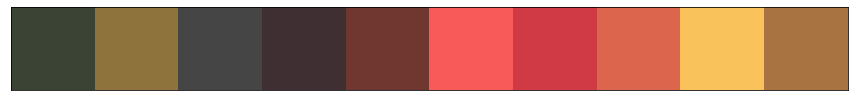

spring


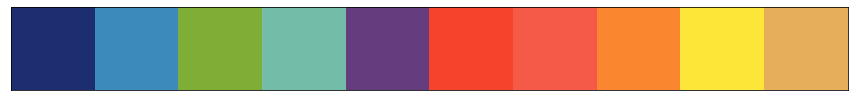

summer


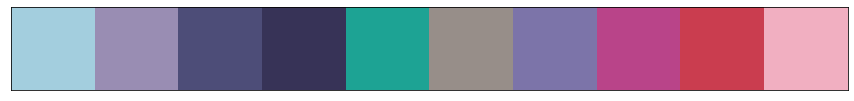

winter


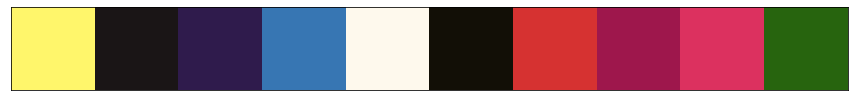

In [8]:
palettes_dir = 'palettes'
reference_palettes = [palette.PaletteRGB().load(palette_filename.replace('\\', '/'), header=True) for palette_filename in glob.glob(palettes_dir + '/*.csv')]

for reference_palette in reference_palettes:
  print(reference_palette.description())
  reference_palette.plot(tile_size=15)

Test image:


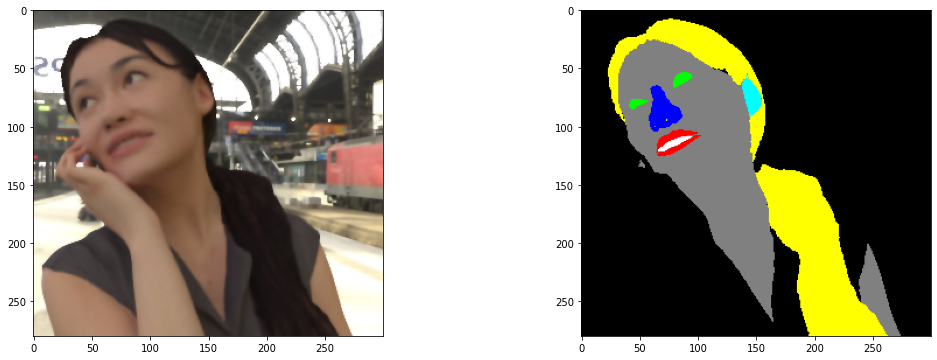

Dominant colors (skin, hair, lips, eyes):


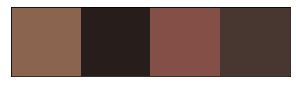

Season: autumn 
Subtone: warm 
Intensity: 0.42753615975379944 
Value: 0.26145752767721814 
Contrast: 0.10588235294117647


In [9]:
# Assigns a specific color to each relevant region of a segmented image.
labels = OrderedDict({
    'skin': [128, 128, 128],
    'hair': [255, 255, 0],
    'lips': [255, 0, 0],
    'eyes': [0, 255, 0],
})


bilateral_filter_size = 5
bilateral_filter_sigma = 125

# test data
fig1 = cv2.cvtColor(cv2.imread('images/fig1.png'), cv2.COLOR_BGR2RGB)
fig1 = cv2.bilateralFilter(fig1, d=bilateral_filter_size, sigmaColor=bilateral_filter_sigma, sigmaSpace=bilateral_filter_sigma)
figseg1 = cv2.cvtColor(cv2.imread('images/figseg1.png'), cv2.COLOR_BGR2RGB)
fig2 = cv2.cvtColor(cv2.imread('images/fig2.png'), cv2.COLOR_BGR2RGB)
fig2 = cv2.bilateralFilter(fig2, d=bilateral_filter_size, sigmaColor=bilateral_filter_sigma, sigmaSpace=bilateral_filter_sigma)
figseg2 = cv2.cvtColor(cv2.imread('images/figseg2.png'), cv2.COLOR_BGR2RGB)

img, img_segmented = fig1, figseg1

print('Test image:')
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_segmented)
plt.show()

# step 1: compute segmentation masks for skin, hair, lips, eyes from segmented images (in this order)
masks = image_processing.compute_segmentation_masks(img_segmented, labels)

# step 2: extract colors of skin, hair, lips and eyes using segmentation masks (in this order)
img_masked = image_processing.apply_masks(img, masks)
dominants = compute_dominants(img_masked, n_candidates=(2, 2, 2, 3), distance_fn=image_processing.rmse, debug=False)
dominants_palette = palette.PaletteRGB('dominants', dominants)
print('Dominant colors (skin, hair, lips, eyes):')
dominants_palette.plot()

# step 3: compute color harmony metrics (subtone, intensity, value, contrast) and metrics_vector 
#         (a binary numpy array of format SIVC obtained by binarizing the metrics)
skin_idx = from_key_to_index(labels, 'skin')
hair_idx = from_key_to_index(labels, 'hair')
lips_idx = from_key_to_index(labels, 'lips')
eyes_idx = from_key_to_index(labels, 'eyes')
subtone = palette.compute_subtone(dominants[lips_idx])
intensity = palette.compute_intensity(dominants[skin_idx])
value = palette.compute_value(dominants[skin_idx], dominants[hair_idx], dominants[eyes_idx])
contrast = palette.compute_contrast(dominants[hair_idx], dominants[eyes_idx])
dominants_palette.compute_metrics_vector(subtone, intensity, value, contrast)

# step 4: Pick season which minimizes Hamming distance between metrics vectors, choosing among seasons with 
#         same subtone
season_palette = palette.classify_palette(dominants_palette, reference_palettes)
print(f'Season: {season_palette.description()} \nSubtone: {subtone} \nIntensity: {intensity} \nValue: {value} \nContrast: {contrast}')

# step 4bis: find optimized thresholds for I, V, C
#            possible solution approach:
#            --> C/I: pick images of autumn/summer for low C/I and winter/spring for high C/I, then compute 
#                     max low C/I and min high C/I, confront these with C/I of current image to choose if high or low
#            --> V: pick images of autumn for low value and summer/spring/winter for high value, then proceed as for C/I
